¿Cuáles son los factores demográficos y de estilo de vida con mayor poder predictivo?

¿Cuál es el impacto de las interacciones BMI×Education e BMI×Income?

¿Cómo se definen los perfiles de riesgo (clusters) y de qué manera varían según la edad y el nivel de educación?

In [1]:
#importamos librerias para manipulación de datos y modelado
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, roc_auc_score, roc_curve
)
import statsmodels.api as sm
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

#definimos compute_ks para medir diferencia máxima entre TPR y FPR
def compute_ks(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    return np.max(np.abs(tpr - fpr))

#definimos woe_iv para calcular Weight of Evidence e Information Value
def woe_iv(df, feature, target):
    lst = []
    eps = 1e-4
    total_event = df[target].sum()
    total_non_event = df.shape[0] - total_event
    for val, d in df.groupby(feature, observed=False):
        event = d[target].sum()
        non_event = d.shape[0] - event
        rate_event = event / total_event if total_event > 0 else eps
        rate_nonevent = non_event / total_non_event if total_non_event > 0 else eps
        woe = np.log((rate_event + eps) / (rate_nonevent + eps))
        iv = (rate_event - rate_nonevent) * woe
        lst.append({'feature': feature, 'value': val, 'woe': woe, 'iv': iv})
    iv_df = pd.DataFrame(lst)
    return iv_df, iv_df['iv'].sum()

In [2]:
#cargamos el dataset y mostramos info general
df = pd.read_csv(r"diabetes_012_health_indicators_BRFSS2015.csv") #cambiar el pathing acorde a donde este el archivo por favor
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [3]:
#definimos variable binaria target a partir de Diabetes_012
df['Diabetes_binary'] = df['Diabetes_012'].map({0:0, 1:1, 2:1})
#creamos categoria BMI_cat segmentando BMI en rangos clinicos
df['BMI_cat'] = pd.cut(df['BMI'], bins=[0,18.5,25,30,100], labels=['Underweight','Normal','Overweight','Obese'])
#calculamos termino de interaccion entre BMI y Education
df['BMI_Education'] = df['BMI'] * df['Education']
#calculamos termino de interaccion entre BMI y Income
df['BMI_Income'] = df['BMI'] * df['Income']
#separamos variable objetivo y la asignamos a y
y = df['Diabetes_binary']
#preparamos matriz de predictores X eliminando columnas no necesarias
X = df.drop(columns=['Diabetes_012','Diabetes_binary'])

In [4]:
#definimos features numericas para escalado
numeric_features = ['BMI','Age','MentHlth','PhysHlth']
#definimos features categoricas excluyendo las numericas
categorical_features = [col for col in X.columns if col not in numeric_features]
#aseguramos incluir la categoria BMI_cat entre las categoricas
categorical_features.append('BMI_cat')
#creamos transformador para variables numericas con StandardScaler
numeric_transformer = Pipeline([('scaler',StandardScaler())])
#creamos transformador para variables categoricas con OneHotEncoder
categorical_transformer = Pipeline([('onehot',OneHotEncoder(handle_unknown='ignore'))])
#combinamos ambos transformadores en un preprocesador
preprocessor = ColumnTransformer([('num',numeric_transformer,numeric_features),('cat',categorical_transformer,categorical_features)])

In [5]:
#dividimos datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#definimos pipeline combinando preprocesador y regresion logistica
clf = Pipeline([('pre',preprocessor),('clf',LogisticRegression(max_iter=1000,class_weight='balanced'))])
#entrenamos el modelo con los datos de entrenamiento
clf.fit(X_train,y_train)
#obtenemos predicciones de clase para el conjunto de prueba
y_pred = clf.predict(X_test)
#obtenemos probabilidades de prediccion para la clase positiva
y_proba = clf.predict_proba(X_test)[:,1]
#calculamos la matriz de confusion
cm = confusion_matrix(y_test,y_pred)
#calculamos la exactitud (accuracy)
acc = accuracy_score(y_test,y_pred)
#calculamos la precision del modelo
prec = precision_score(y_test,y_pred)
#calculamos el recall del modelo
rec = recall_score(y_test,y_pred)
#calculamos el area bajo la curva ROC (AUC)
auc = roc_auc_score(y_test,y_proba)
#calculamos la estadistica KS
ks = compute_ks(y_test,y_proba)
#mostramos todas las metricas en un solo print
print(cm,acc,prec,rec,auc,ks)

[[30827 11914]
 [ 1880  6115]] 0.7281220435193945 0.33917577236674246 0.7648530331457161 0.8201292925132091 0.4895675259941935


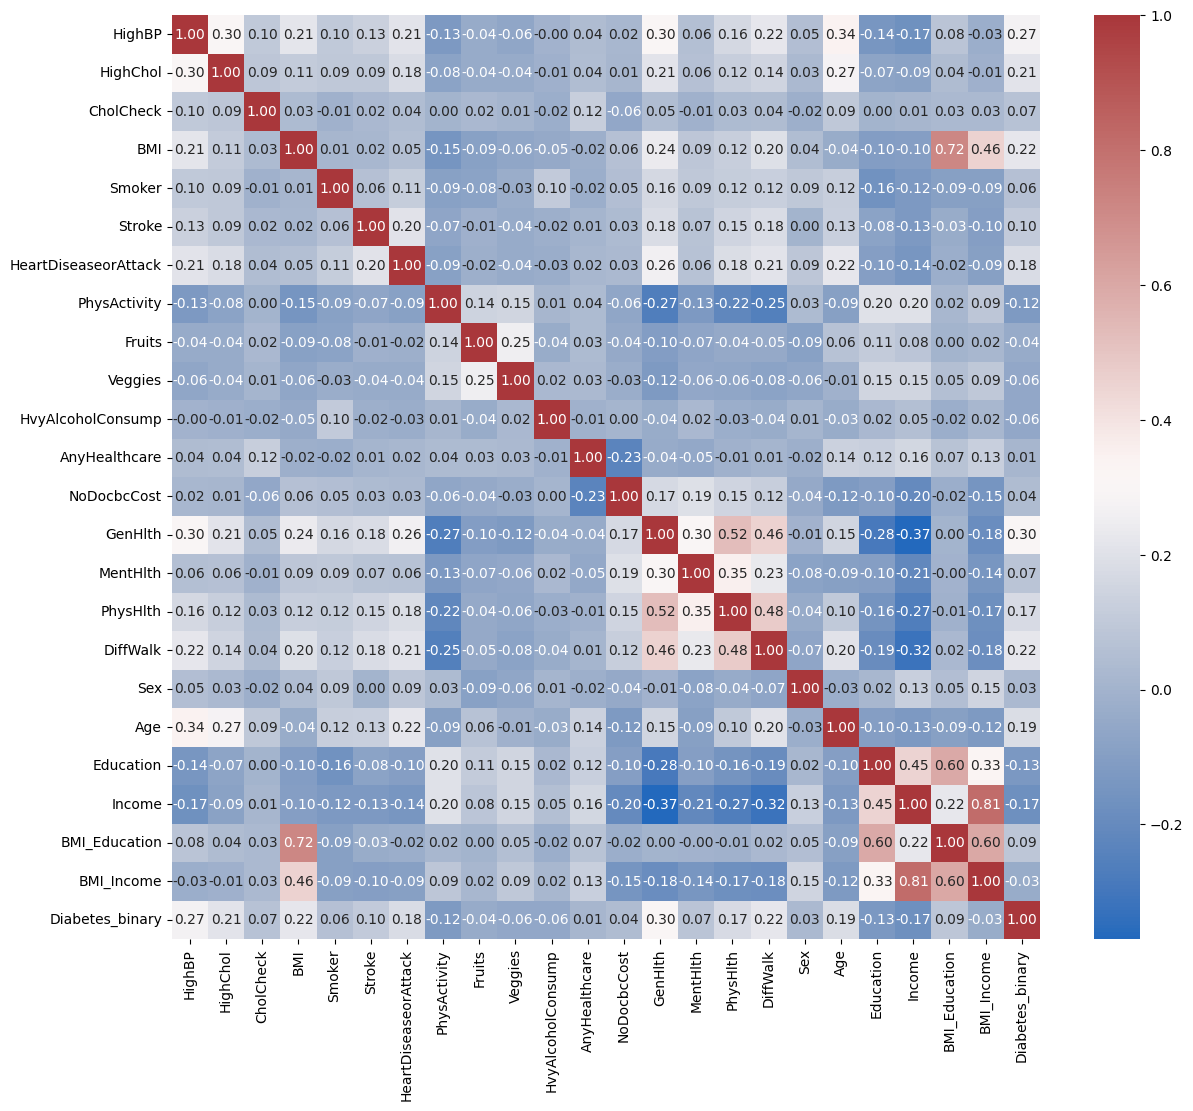

In [6]:
#definimos columnas numericas para correlacion
num_corr_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col not in ('Diabetes_012','Diabetes_binary')]
#calculamos matriz de correlacion completa incluyendo el target
corr_full = df[num_corr_cols + ['Diabetes_binary']].corr()
#configuramos figura de gran tamano
plt.figure(figsize=(14,12))
#graficamos heatmap con anotaciones de correlacion
sns.heatmap(corr_full, annot=True, fmt=".2f", cmap="vlag")
#mostramos la grafica
plt.show()

In [7]:
#definimos feat_num igual a lista de features numericas
feat_num = numeric_features
#definimos feat_cat extrayendo nombres generados por onehot en el pipeline
feat_cat = clf.named_steps['pre'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
#combinamos nombres de features numericas y categoricas en una sola lista
feature_names = feat_num + feat_cat.tolist()
#creamos serie de coeficientes asociando cada coef a su nombre de feature
coefs = pd.Series(clf.named_steps['clf'].coef_[0], index=feature_names)
#identificamos las 5 variables con coeficientes mas altos (mayor riesgo)
top_pos = coefs.sort_values(ascending=False).head(5)
#identificamos las 5 variables con coeficientes mas bajos (mas protectoras)
top_neg = coefs.sort_values().head(5)
#mostramos las listas de top positivos y negativos
print(top_pos, top_neg)

BMI_Income_290.0       1.177255
BMI_Income_399.0       1.166074
BMI_Income_441.0       1.011591
BMI_Education_312.0    0.957013
BMI_Education_290.0    0.909277
dtype: float64 BMI_Education_36.0    -1.313624
BMI_Education_342.0   -1.138885
GenHlth_1.0           -1.135907
BMI_Income_51.0       -1.033049
BMI_Education_450.0   -1.008655
dtype: float64


In [8]:
#definimosdiccionarioparaalmacenariv
iv_summary = {}
#iteramosporcadasfeaturecategorica
for col in categorical_features:
    #calculamoswoeyivporfeature
    _, iv = woe_iv(df, col, 'Diabetes_binary')
    #almacenamoselvalorivparacadafeature
    iv_summary[col] = iv
    #mostramosfeatureyiv
    print(col, iv)

HighBP 0.5744807441778963
HighChol 0.33538437745331295
CholCheck 0.06211494674040327
Smoker 0.029459473411621716
Stroke 0.061623098668276755
HeartDiseaseorAttack 0.17800763453256177
PhysActivity 0.10032596859092043
Fruits 0.013089974889868971
Veggies 0.024476646139284085
HvyAlcoholConsump 0.03228730578568433
AnyHealthcare 0.0015817383444868063
NoDocbcCost 0.009911888515639783
GenHlth 0.7480898890888145
DiffWalk 0.2980033896503216
Sex 0.006565936306429477
Education 0.12757216983953365
Income 0.2282261807350413
BMI_cat 0.3838324194229409
BMI_Education 0.3369474069134246
BMI_Income 0.38981204680510473
BMI_cat 0.3838324194229409


In [9]:
#definimos weak_corr como features con correlacion menor a 0.05
weak_corr = [feat for feat, r in corr_full['Diabetes_binary'].items() if abs(r) < 0.05 and feat != 'Diabetes_binary']
#definimos weak_iv como features con iv menor a 0.02
weak_iv = [col for col, iv in iv_summary.items() if iv < 0.02]
#unimos weak_corr y weak_iv en weak_feats para eliminar duplicados
weak_feats = set(weak_corr + weak_iv)
#mostramos weak_feats
print(weak_feats)

{'Fruits', 'Sex', 'NoDocbcCost', 'BMI_Income', 'AnyHealthcare'}


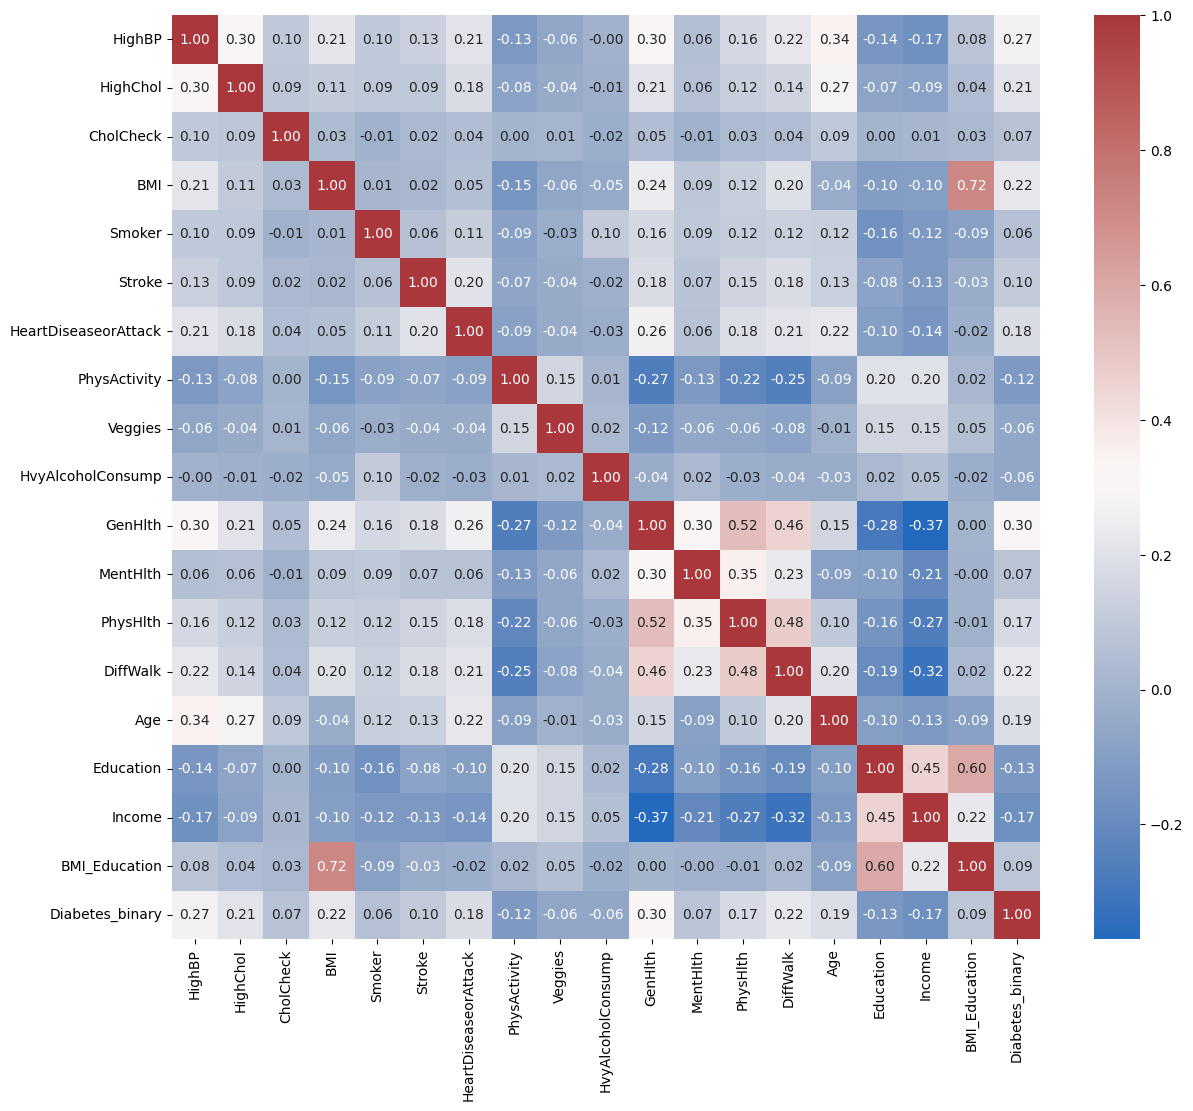

In [10]:
#definimos num_reduced excluyendo variables debiles
num_reduced = [feat for feat in num_corr_cols if feat not in weak_feats]
#calculamos matriz de correlacion reducida
corr_reduced = df[num_reduced + ['Diabetes_binary']].corr()
#configuramos figura de tamano personalizado
plt.figure(figsize=(14,12))
#graficamos heatmap de correlaciones reducidas
sns.heatmap(corr_reduced, annot=True, fmt=".2f", cmap="vlag")
#mostramos grafica
plt.show()

In [11]:
#definimos X2 eliminando features debiles
X2 = X.drop(columns=weak_feats)
#definimos lista numeric2 de numericas que siguen en X2
numeric2 = [f for f in numeric_features if f in X2.columns]
#definimos lista categorical2 de categoricas que siguen en X2
categorical2 = [f for f in categorical_features if f in X2.columns]
#creamos nuevo pre2 con transformadores filtrados
pre2 = ColumnTransformer([('num',numeric_transformer,numeric2),('cat',categorical_transformer,categorical2)])
#definimos clf2 pipeline con pre2 y regresion logistica
clf2 = Pipeline([('pre',pre2),('clf',LogisticRegression(max_iter=1000,class_weight='balanced'))])
#dividimos X2 e y en entrenamiento y prueba
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y,test_size=0.2,random_state=42,stratify=y)
#entrenamos modelo clf2 con datos de entrenamiento
clf2.fit(X2_train,y2_train)
#obtenemos predicciones de clase con clf2 en X2_test
y2_pred = clf2.predict(X2_test)
#obtenemos probabilidades positivas con clf2 en X2_test
y2_proba = clf2.predict_proba(X2_test)[:,1]
#calculamos matriz de confusion para segundo modelo
cm2 = confusion_matrix(y2_test,y2_pred)
#calculamos accuracy para segundo modelo
acc2 = accuracy_score(y2_test,y2_pred)
#calculamos precision para segundo modelo
prec2 = precision_score(y2_test,y2_pred)
#calculamos recall para segundo modelo
rec2 = recall_score(y2_test,y2_pred)
#calculamos auc para segundo modelo
auc2 = roc_auc_score(y2_test,y2_proba)
#calculamos ks para segundo modelo
ks2 = compute_ks(y2_test,y2_proba)
#mostramos todas las metricas del segundo modelo
print(cm2,acc2,prec2,rec2,auc2,ks2)

#TN = 30825, FP = 11916, FN = 1885, TP = 6110

[[30825 11916]
 [ 1885  6110]] 0.7279840744244718 0.338954843004549 0.7642276422764228 0.8193507181196502 0.48680141695564705


In [12]:
#creamos matriz con intercepto y variables de interaccion
X_int = sm.add_constant(df[['BMI','Education','Income','BMI_Education','BMI_Income']])
#entrenamos model logistico detallado con statsmodels
res_int = sm.Logit(df['Diabetes_binary'], X_int).fit(disp=False)
#mostramos resumen estadistico del logit con coeficientes y pvalues
print(res_int.summary())

                           Logit Regression Results                           
Dep. Variable:        Diabetes_binary   No. Observations:               253680
Model:                          Logit   Df Residuals:                   253674
Method:                           MLE   Df Model:                            5
Date:                Mon, 12 May 2025   Pseudo R-squ.:                 0.07800
Time:                        22:57:22   Log-Likelihood:            -1.0190e+05
converged:                       True   LL-Null:                   -1.1052e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.3622      0.119    -11.491      0.000      -1.595      -1.130
BMI               0.0474      0.004     12.399      0.000       0.040       0.055
Education        -0.2461      0.027     

In [13]:
#definimos features para clustering
cluster_feats = ['BMI','HighBP','HighChol','PhysActivity','Fruits','Veggies']
#extraemos columnas del dataframe en cl_data
cl_data = df[cluster_feats]
#escalamos datos con StandardScaler para clustering
cl_scaled = StandardScaler().fit_transform(cl_data)
#aplicamos KMeans y obtenemos clusters
clusters = KMeans(n_clusters=3,random_state=42).fit_predict(cl_scaled)
#asignamos clusters al dataframe
df['Cluster'] = clusters
#mostramos distribucion de registros por cluster edad y educacion
print(df.groupby(['Cluster','Age','Education']).size().unstack(fill_value=0))

Education     1.0  2.0  3.0   4.0   5.0   6.0
Cluster Age                                  
0       1.0     1    5   39   284   291   131
        2.0     0   14   53   318   387   416
        3.0     2   35  114   524   599   683
        4.0     4   67  140   679   884   989
        5.0     5   87  232   887  1014  1164
        6.0     8  115  244  1498  1242  1348
        7.0    10  170  452  2247  1890  1610
        8.0    10  178  504  2817  2383  1818
        9.0    14  199  477  2828  2575  2265
        10.0    5  215  440  2580  2473  2241
        11.0    8  209  484  2304  1690  1570
        12.0    8  180  455  1882  1232  1041
        13.0    4  268  484  2318  1371  1365
1       1.0     2   13  127  1196  1792  1065
        2.0     1   22  101   815  1455  2704
        3.0     3   44  187  1071  1780  3767
        4.0     2   54  159  1151  1912  4391
        5.0     2   66  150  1131  1984  4741
        6.0     2   64  146  1369  2024  4930
        7.0     2   59  168  1781 